# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [9]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler


The number of samples: 186
The number of columns: 494


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

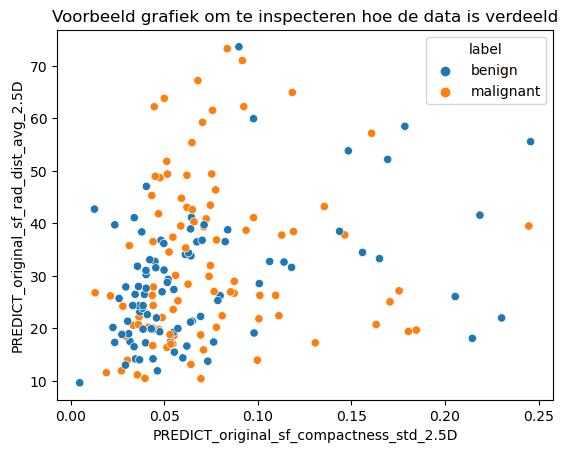

In [3]:
# Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

sb.scatterplot(x ="PREDICT_original_sf_compactness_std_2.5D", y = "PREDICT_original_sf_rad_dist_avg_2.5D", data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

### Check normality

In [8]:
# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   #drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

## Normality check
# P-waarde berekenen voor elke feature (statistiek test om te testen of H0: Data is normaal verdeeld)
p_values = []
for features in X.columns:
    _, p = normaltest(X[features])
    p_values.append(p)

for i, features in enumerate(X.columns):
    print("Variable:", features)
    print("p-value:", p_values[i])
    if p_values[i] < 0.05:
        print("The variable is not normally distributed")
    else:
        print("The variable is normally distributed")

c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1670: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1774: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


Variable: PREDICT_original_sf_compactness_avg_2.5D
p-value: 1.145662534663526e-10
The variable is not normally distributed
Variable: PREDICT_original_sf_compactness_std_2.5D
p-value: 5.082112458342082e-16
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_avg_2.5D
p-value: 4.280298135711637e-06
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_std_2.5D
p-value: 2.4907255505070975e-14
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_avg_2.5D
p-value: 3.0991062140741755e-09
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_std_2.5D
p-value: 3.467791393271106e-23
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_avg_2.5D
p-value: 3.1390583766102673e-26
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_std_2.5D
p-value: 1.6120456237759444e-28
The variable is not normally distributed
Variable: PREDICT_original

## Splitting data into test and trainingset

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


<class 'pandas.core.frame.DataFrame'>
Training set dimensies: (148, 493) (148,)
Testing set dimensies: (38, 493) (38,)


VANAF HIER ALLEEN NOG MAAR DINGEN DOEN OP DE TRAININGSET!!

## Finding missing values in the data

In [15]:
features = y_train

nullen = X_train.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

X_train = X_train.fillna(0)

patient0={}
for patients in X_train.index:
    zero_count1 = (X_train.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print("Hoeveelheid nullen per patient: ")
print(patient0)

# we kunnen het ook doen met:
# patient0=[]
# for patients in data.index:
#     zero_count = (data.loc[patients]==0).sum()
#     patient0.append((patients, zero_count))
# even kijken welke output we fijner vinden werken. 

features0={}
for features in X_train.columns:
    zero_count2 = (X_train[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print("Hoeveelheid nullen per feature: ")
print(features0)

#print(data.head)

Aantal nullen in de data: 3464
Hoeveelheid nullen per patient: 
{'Liver-124_0': 27, 'Liver-136_0': 24, 'Liver-151_0': 24, 'Liver-032_0': 23, 'Liver-013_0': 24, 'Liver-042_0': 21, 'Liver-052_0': 24, 'Liver-057_0': 25, 'Liver-094_0': 20, 'Liver-091_0': 21, 'Liver-067_0': 23, 'Liver-039_0': 24, 'Liver-056_0': 23, 'Liver-099_0': 25, 'Liver-154_0': 24, 'Liver-097_0': 21, 'Liver-003_0': 22, 'Liver-113_0': 23, 'Liver-047_0': 25, 'Liver-066_0': 26, 'Liver-061_0': 24, 'Liver-182_0': 23, 'Liver-179_0': 20, 'Liver-027_0': 24, 'Liver-160_0': 22, 'Liver-105_0': 25, 'Liver-118_0': 24, 'Liver-037_0': 24, 'Liver-125_0': 24, 'Liver-023_0': 25, 'Liver-149_0': 22, 'Liver-079_0': 21, 'Liver-175_0': 23, 'Liver-012_0': 25, 'Liver-109_0': 23, 'Liver-147_0': 25, 'Liver-007_0': 25, 'Liver-028_0': 23, 'Liver-096_0': 27, 'Liver-005_0': 22, 'Liver-033_0': 24, 'Liver-083_0': 24, 'Liver-133_0': 22, 'Liver-086_0': 16, 'Liver-145_0': 25, 'Liver-011_0': 25, 'Liver-121_0': 17, 'Liver-134_0': 24, 'Liver-001_0': 25, 'Liv

## Scaling the data

Index(['PREDICT_original_sf_compactness_avg_2.5D',
       'PREDICT_original_sf_compactness_std_2.5D',
       'PREDICT_original_sf_rad_dist_avg_2.5D',
       'PREDICT_original_sf_rad_dist_std_2.5D',
       'PREDICT_original_sf_roughness_avg_2.5D',
       'PREDICT_original_sf_roughness_std_2.5D',
       'PREDICT_original_sf_convexity_avg_2.5D',
       'PREDICT_original_sf_convexity_std_2.5D',
       'PREDICT_original_sf_cvar_avg_2.5D',
       'PREDICT_original_sf_cvar_std_2.5D',
       ...
       'PREDICT_original_phasef_phasesym_std_WL3_N5',
       'PREDICT_original_phasef_phasesym_skewness_WL3_N5',
       'PREDICT_original_phasef_phasesym_kurtosis_WL3_N5',
       'PREDICT_original_phasef_phasesym_peak_WL3_N5',
       'PREDICT_original_phasef_phasesym_peak_position_WL3_N5',
       'PREDICT_original_phasef_phasesym_range_WL3_N5',
       'PREDICT_original_phasef_phasesym_energy_WL3_N5',
       'PREDICT_original_phasef_phasesym_quartile_range_WL3_N5',
       'PREDICT_original_phasef_phases

[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen')]

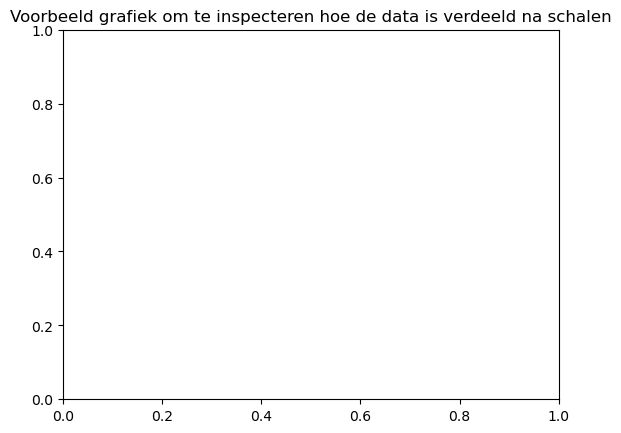

In [24]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train) #Dit schaalt de data
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X.columns) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

# Plotten om te zien hoe het er nu uitziet: 
X_train_normalized['label'] = y_train
print(X_train_normalized.columns)
sb.scatterplot(x ="PREDICT_original_sf_compactness_std_2.5D", y = "PREDICT_original_sf_rad_dist_avg_2.5D", data=X_train_normalized, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")
